<a href="https://colab.research.google.com/github/Andres-lng/ML-DL-FINALPROJECT/blob/main/FinalProject_ANLT202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import urllib.request

# Create a folder called 'data'
if not os.path.exists('data'):
    os.makedirs('data')

# The larger one (churn-bigml-80.csv, 2666 rows) for training and cross-validation,
# The smaller one (churn-bigml-20.csv, 667 rows) for final testing/evaluation.
# No need for additional splitting.

# Download the two dataset files automatically
files = {
    'https://raw.githubusercontent.com/SaskPolytechBIS/ML-DP-FinalProject/main/data/churn-bigml-80.csv': 'data/churn-bigml-80.csv',
    'https://raw.githubusercontent.com/SaskPolytechBIS/ML-DP-FinalProject/main/data/churn-bigml-20.csv': 'data/churn-bigml-20.csv'
}


for url, path in files.items():
    if not os.path.exists(path):
        print(f"Downloading {path} ...")
        urllib.request.urlretrieve(url, path)
        print("Done!")
    else:
        print(f"{path} already exists.")

df_train = pd.read_csv('data/churn-bigml-80.csv')
df_test  = pd.read_csv('data/churn-bigml-20.csv')

print(df_train.shape, df_test.shape)

# 2. DATA EXPLORATION & PREPROCESSING
df_train.info()
df_test.info()

# handling missing values
print(df_train.isnull().sum().sum(), df_test.isnull().sum().sum())

# Compute regression target: total_monthly_charge
df_train['total_monthly_charge'] = (df_train['Total day charge'] + df_train['Total eve charge'] +
                                    df_train['Total night charge'] + df_train['Total intl charge'])
df_test['total_monthly_charge'] = (df_test['Total day charge'] + df_test['Total eve charge'] +
                                   df_test['Total night charge'] + df_test['Total intl charge'])

# Map Churn to 0/1
df_train['Churn'] = df_train['Churn'].astype(int)
df_test['Churn'] = df_test['Churn'].astype(int)

# Features and targets
X_train = df_train.drop(['Churn', 'total_monthly_charge'], axis=1)
y_clf_train = df_train['Churn']
y_reg_train = df_train['total_monthly_charge']

X_test = df_test.drop(['Churn', 'total_monthly_charge'], axis=1)
y_clf_test = df_test['Churn']
y_reg_test = df_test['total_monthly_charge']

# Treat Area code as categorical
X_train['Area code'] = X_train['Area code'].astype(str)
X_test['Area code'] = X_test['Area code'].astype(str)

# Categorical and numerical columns
cat_cols = ['State', 'Area code', 'International plan', 'Voice mail plan']
num_cols = [col for col in X_train.columns if col not in cat_cols]

print("Categorical:", cat_cols)
print("Numerical:", num_cols)

# Outliers check (no handling needed, values reasonable)
print(X_train[num_cols].describe())

# 3. PREPROCESSING PIPELINE SETUP
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])


data/churn-bigml-80.csv already exists.
data/churn-bigml-20.csv already exists.
(2666, 20) (667, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float

**BUSINESS PROBLEM DEFINITION**

Classification Task : Predict 'Churn' (True/False)


*   Business Impact: Reducing churn by 1% can increase profit by millions
*   Early identification : targeted retention campaigns



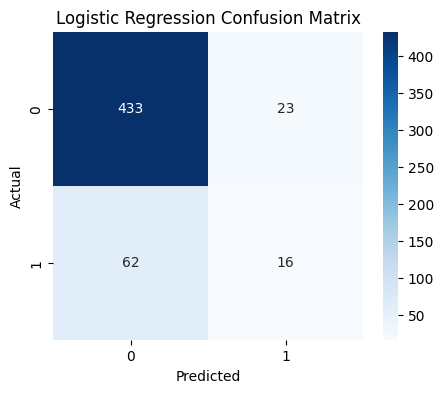

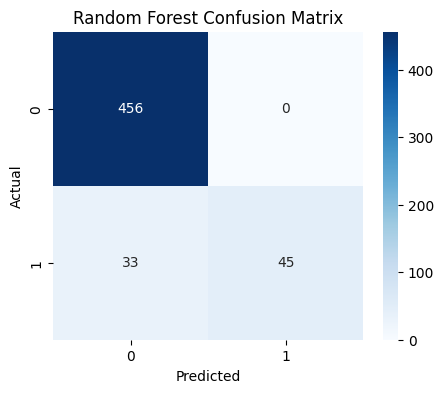


Logistic Regression
Accuracy: 0.8408239700374532
Precision: 0.41025641025641024
Recall: 0.20512820512820512
F1 Score: 0.27350427350427353

Random Forest
Accuracy: 0.9382022471910112
Precision: 1.0
Recall: 0.5769230769230769
F1 Score: 0.7317073170731707
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_depth': 20}

Tuned Random Forest
Accuracy: 0.9288389513108615
Precision: 1.0
Recall: 0.5128205128205128
F1 Score: 0.6779661016949152


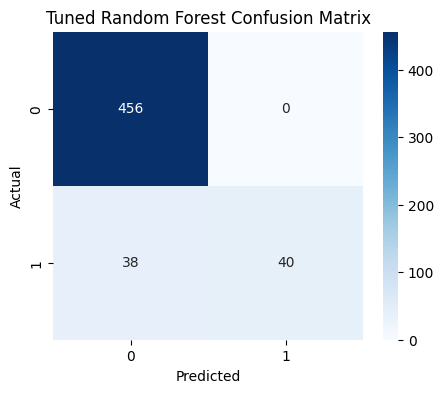


Pipeline Logistic Regression
Accuracy: 0.8408239700374532
Precision: 0.41025641025641024
Recall: 0.20512820512820512
F1 Score: 0.27350427350427353


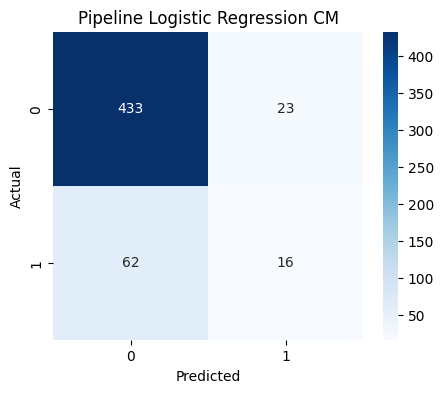

In [ ]:
# Train/Validation Split
from sklearn.model_selection import train_test_split

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_clf_train,
    test_size=0.2,
    random_state=42,
    stratify=y_clf_train
)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg_clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

logreg_clf.fit(X_train_sub, y_train_sub)
logreg_pred = logreg_clf.predict(X_val)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42))
])

rf_clf.fit(X_train_sub, y_train_sub)
rf_pred = rf_clf.predict(X_val)

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_scores(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))


import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


plot_cm(y_val, logreg_pred, "Logistic Regression Confusion Matrix")
plot_cm(y_val, rf_pred, "Random Forest Confusion Matrix")

# Print results
print_scores("Logistic Regression", y_val, logreg_pred)
print_scores("Random Forest", y_val, rf_pred)



from sklearn.model_selection import RandomizedSearchCV

# Search space for Random Forest
param_grid = {
    'model__n_estimators': [200, 300, 400, 500, 600],
    'model__max_depth': [None, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Pipeline
rf_tune = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# RandomizedSearchCV:
#   - Faster than GridSearch
#   - Explores random combinations
#   - Optimizes F1 score
search = RandomizedSearchCV(
    rf_tune,
    param_grid,
    n_iter=10,          # number of random searches
    scoring='f1',       # F1 is better for churn balance
    cv=3,               # 3-fold cross-validation
    n_jobs=-1,          # use all CPU cores
    random_state=42,
    verbose=1
)

# Fit tuning using train/validation split
search.fit(X_train_sub, y_train_sub)

# Extract best model and evaluate it
best_rf = search.best_estimator_
tuned_pred = best_rf.predict(X_val)

print("Best Parameters:", search.best_params_)
print_scores("Tuned Random Forest", y_val, tuned_pred)
plot_cm(y_val, tuned_pred, "Tuned Random Forest Confusion Matrix")


clf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit on the internal training split
clf_pipeline.fit(X_train_sub, y_train_sub)

# Predict on validation set
pipeline_pred = clf_pipeline.predict(X_val)

# Show results
print_scores("Pipeline Logistic Regression", y_val, pipeline_pred)
plot_cm(y_val, pipeline_pred, "Pipeline Logistic Regression CM")







**BUSINESS PROBLEM DEFINITION**

Regression Task : Predict total_monthly_charge


*   Business Impact: Accurate revenue forecasting, anomaly detection, dynamic pricing, upsell opportunities



In [ ]:
# Regression Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Realign the regression target to match the same rows that were selected for X_train and X_val
y_reg_train_sub = y_reg_train.loc[y_train_sub.index]
y_reg_val = y_reg_train.loc[y_val.index]

# Linear Regression
linreg_pipe = Pipeline([
    ('prep', preprocessor),
    ('reg', LinearRegression())
])
linreg_pipe.fit(X_train_sub, y_reg_train_sub)
linreg_reg_pred = linreg_pipe.predict(X_val)

# Random Forest Regressor
rf_reg_pipe = Pipeline([
    ('prep', preprocessor),
    ('reg', RandomForestRegressor(n_estimators=500, random_state=42))
])
rf_reg_pipe.fit(X_train_sub, y_reg_train_sub)
rf_reg_pred = rf_reg_pipe.predict(X_val)

def print_regression_report(name, y_true, y_pred):
    print(f"\n{name}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²   : {r2_score(y_true, y_pred):.4f}")

print_regression_report("Linear Regression", y_reg_val, linreg_reg_pred)
print_regression_report("Random Forest Regressor", y_reg_val, rf_reg_pred)

# Hyperparameter Tuning
param_dist_reg = {
    'reg__n_estimators': [300, 500, 700],
    'reg__max_depth': [None, 15, 25],
    'reg__min_samples_split': [2, 5],
    'reg__min_samples_leaf': [1, 2]
}

reg_tuner = RandomizedSearchCV(
    rf_reg_pipe, param_dist_reg, n_iter=15, scoring='r2', cv=5, n_jobs=-1, random_state=42
)
reg_tuner.fit(X_train_sub, y_reg_train_sub)

print("Best Regressor Params:", reg_tuner.best_params_)
best_reg_pred = reg_tuner.best_estimator_.predict(X_val)
print_regression_report("Tuned Random Forest Regressor", y_reg_val, best_reg_pred)

# Final Regression Pipeline
final_reg_pipeline = reg_tuner.best_estimator_
final_reg_pipeline.fit(X_train, y_reg_train)





Linear Regression
MAE  : 0.0000
RMSE : 0.0000
R²   : 1.0000

Random Forest Regressor
MAE  : 0.8980
RMSE : 1.2734
R²   : 0.9844


KeyboardInterrupt: 

In [ ]:
#Deep Learning Model
import tensorflow as tf
from tensorflow.keras import layers, models

# Fit the preprocessor ONLY on training data, then transform both sets.
X_train_dl = preprocessor.fit_transform(X_train)
X_test_dl = preprocessor.transform(X_test)

# Build a simple feedforward neural network
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_dl.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_dl, y_clf_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0
)

# Convert probability outputs into class labels (0 or 1)
dl_pred = (model.predict(X_test_dl) > 0.5).astype(int).flatten()

# Evaluate and plot confusion matrix
print_scores("Deep Learning Churn Model", y_clf_test, dl_pred)
plot_cm(y_clf_test, dl_pred, "Deep Learning Confusion Matrix")

# Regression Final
final_reg_pred = final_reg_pipeline.predict(X_test)
print_regression_report("Final Random Forest Regressor", y_reg_test, final_reg_pred)